In [200]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill
import plotly.graph_objects as go
import random

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.queries.causal_insight import CausalInsight
from cities.modeling.model_interactions import model_cities_interaction
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_wide_data_for_inference, train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [71]:
interventions = list_interventions()
outcomes = list_outcomes()
shifts = [1,2,3]

outcome = 'unemployment_rate'
intervention='spending_commerce'
shift = 2
intervened_value = 0.7
fips = 1005

# if you want random intervention and outcome
# this should be uncommented
# intervention = random.choice(interventions)
# outcome = random.choice(outcomes)
# shift = random.choice(shifts)

In [180]:
data = DataGrabber()
data.get_features_wide(["gdp"])
gdp = data.wide["gdp"]
values = [round(i * 0.1, 1) for i in range(1, 10)]


In [192]:
intervened_value = random.choice(values)
fips = random.choice(gdp['GeoFIPS'])

intervention = random.choice(interventions)
outcome = random.choice(outcomes)
shift = random.choice(shifts)
print(intervention)
print(intervened_value)

spending_transportation
0.4


In [193]:
# initiate the query object

ci = CausalInsight(
    outcome_dataset = outcome,
    intervention_dataset= intervention,
    num_samples=1000,
    )

In [194]:
# load guide and generate samples
ci.load_guide(forward_shift=shift)
ci.generate_samples()

# you may now use samples as if they were posterior samples
# in a pyro trace

print(ci.samples.keys())

# this will be too low-level for a regular user

dict_keys(['bias_Y', 'bias_T', 'weight_TY', 'sigma_T', 'sigma_Y', 'bias_X', 'sigma_X', 'weight_XT', 'weight_XY', 'bias_stateT', 'bias_stateY', 'bias_stateX', 'bias_timeT', 'bias_timeY', 'X', 'T', 'Y', 'mean_X', 'bias_stateT_tiled', 'mean_T', 'bias_stateY_tiled', 'mean_Y'])


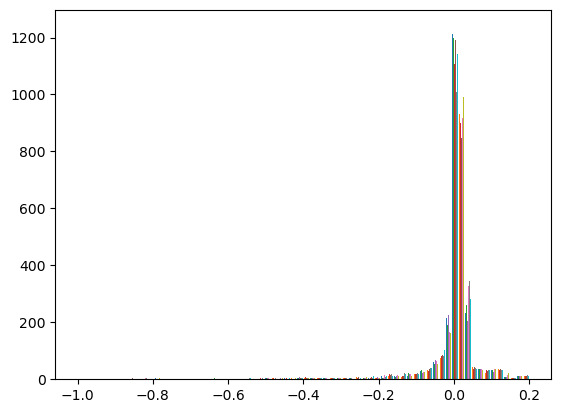

In [195]:
# you can, however, plot residuals

ci.plot_residuals()

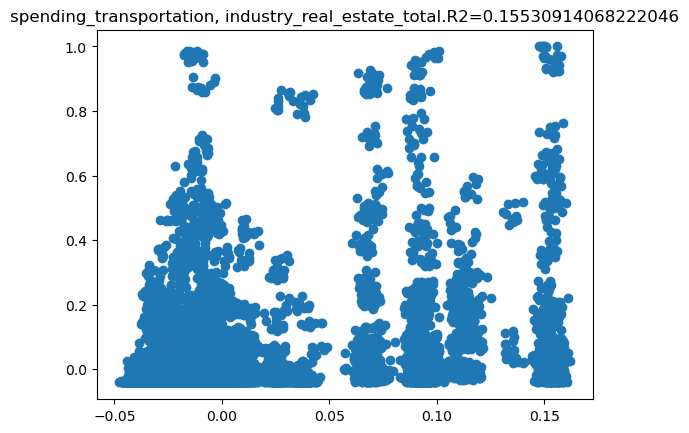

In [196]:
# and run a posterior predictive check
# note however that for some combinations of intervention and outcome
# the predictors aren't amazing
# so R2 can be low

ci.predictive_check()

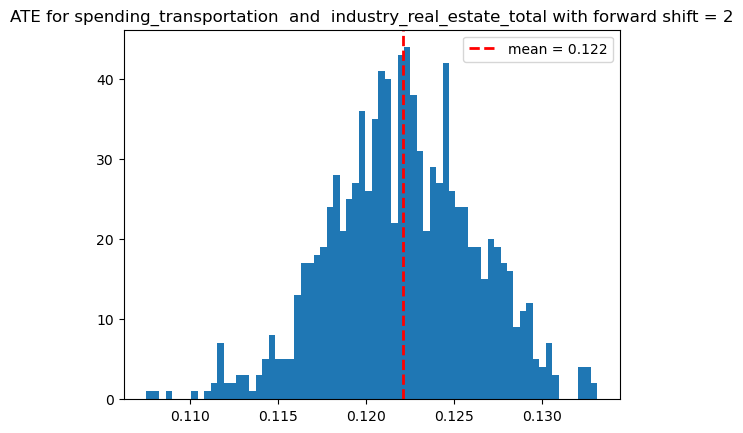

In [197]:
# average treatment effect estimate across the country
# we still need to rescale to the original units
ci.estimate_ATE()

In [198]:
#suppose now we want to generate samples for all three steps forward
ci.generate_tensed_samples()

# see what intervention years are available

ci.data['years_available']

# pass a particular intervention level and fips code
ci.get_fips_predictions(intervened_value=intervened_value, fips = fips)

# inspect predictions
display(ci.predictions)

8


,year,observed,mean,low,high
2018,2018,0.103772,0.103772,0.103772,0.103772
2019,2019,0.110636,0.164056,0.161149,0.166862
2020,2020,0.114731,0.165263,0.161840,0.168800
2021,2021,0.11019,0.161458,0.157856,0.165115


In [201]:
ci.plot_predictions(range_multiplier=1)